In [129]:
### Data Collection
import pandas_datareader as pdr

In [130]:
df = pdr.get_data_tiingo('AAPL', api_key='42339adc748250f3771ee40550b91af60a4074f5')

In [131]:
df.to_csv('Stock.csv')

In [132]:
import pandas as pd

In [133]:
df=pd.read_csv('Stock.csv')

In [134]:
print(df)

     symbol                       date   close  ...  adjVolume  divCash  splitFactor
0      AAPL  2016-11-28 00:00:00+00:00  111.57  ...  108775932      0.0          1.0
1      AAPL  2016-11-29 00:00:00+00:00  111.46  ...  114115000      0.0          1.0
2      AAPL  2016-11-30 00:00:00+00:00  110.52  ...  144649032      0.0          1.0
3      AAPL  2016-12-01 00:00:00+00:00  109.49  ...  148347448      0.0          1.0
4      AAPL  2016-12-02 00:00:00+00:00  109.90  ...  106111988      0.0          1.0
...     ...                        ...     ...  ...        ...      ...          ...
1253   AAPL  2021-11-18 00:00:00+00:00  157.87  ...  137827673      0.0          1.0
1254   AAPL  2021-11-19 00:00:00+00:00  160.55  ...  117305597      0.0          1.0
1255   AAPL  2021-11-22 00:00:00+00:00  161.02  ...  117467889      0.0          1.0
1256   AAPL  2021-11-23 00:00:00+00:00  161.41  ...   96041899      0.0          1.0
1257   AAPL  2021-11-24 00:00:00+00:00  161.94  ...   69463623   

In [135]:
df1=df.reset_index()['close']

In [136]:
df1

0       111.57
1       111.46
2       110.52
3       109.49
4       109.90
         ...  
1253    157.87
1254    160.55
1255    161.02
1256    161.41
1257    161.94
Name: close, Length: 1258, dtype: float64

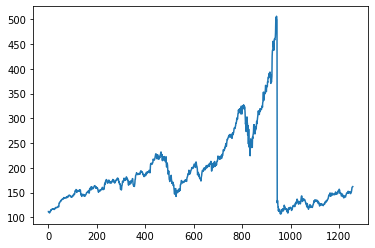

In [137]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [138]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [139]:
print(df1)

[[0.01184721]
 [0.0115717 ]
 [0.00921728]
 ...
 [0.13570445]
 [0.13668128]
 [0.13800877]]


In [140]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [141]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [142]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [143]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [144]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [145]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [146]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [147]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [148]:
#model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

In [149]:
#model.save_weights("stockweights.h5")

In [150]:
model.load_weights("stockweights.h5")

In [151]:
import tensorflow as tf

In [152]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [153]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [154]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

204.617832301394

In [155]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

193.51875770821513

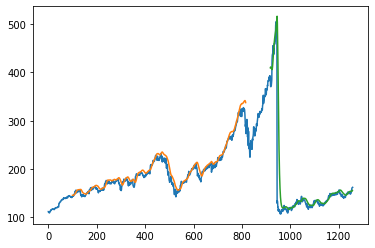

In [156]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [157]:
len(test_data)

441

In [158]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape


(1, 101)

In [159]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [160]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.09450219 0.09117095 0.09585473 0.09432686 0.09718222 0.1059737
 0.10429555 0.09906074 0.08919224 0.09845961 0.09658109 0.10008766
 0.10449593 0.10557295 0.10001252 0.09552912 0.09718222 0.09773325
 0.09688165 0.10149029 0.10046337 0.10073889 0.09843456 0.09830933
 0.09708203 0.09773325 0.10532248 0.10584847 0.11090795 0.10857858
 0.0989856  0.09983719 0.10356919 0.10737633 0.10715091 0.10399499
 0.10194114 0.10459612 0.11591735 0.11268629 0.11438948 0.11724483
 0.11887289 0.12485911 0.12090169 0.11829681 0.10552286 0.10697558
 0.10339386 0.10567314 0.10507201 0.09823419 0.09041954 0.09164684
 0.0977082  0.10016281 0.10038823 0.09650595 0.0878397  0.09014402
 0.08681277 0.08969317 0.08090169 0.08583594 0.08806512 0.09129618
 0.09031935 0.09009393 0.08683782 0.085335   0.09247339 0.09517846
 0.09946149 0.10499687 0.10624922 0.10680025 0.10482154 0.10469631
 0.1063995  0.10522229 0.11453976 0.10760175 0.10549781 0.10815279
 0.11183469 0.1105072  0.1113087  0.10920476 0.1101

In [161]:
day_new=np.arange(1,100)
day_pred=np.arange(101,131)

In [162]:
import matplotlib.pyplot as plt
len(df1)

1258

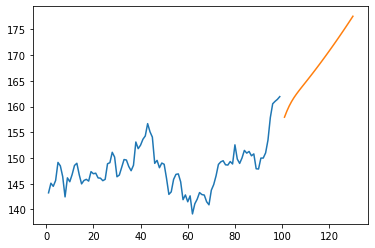

In [163]:
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

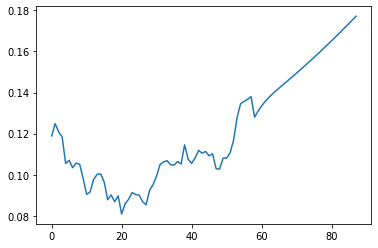

In [164]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [165]:
df3=scaler.inverse_transform(df3).tolist()

In [166]:
len(df3)

1288

[[111.57], [111.46], [110.52], [109.49], [109.9], [109.11], [109.95000000000002], [111.02999999999999], [112.12000000000002], [113.95], [113.3], [115.19000000000001], [115.19000000000001], [115.82], [115.97], [116.63999999999999], [116.95], [117.06], [116.29], [116.52], [117.26], [116.76], [116.73], [115.82], [116.15000000000002], [116.02], [116.61], [117.91000000000001], [118.99], [119.11], [119.74999999999999], [119.25], [119.04], [120.0], [119.99000000000001], [119.78], [120.0], [120.07999999999998], [119.96999999999998], [121.87999999999998], [121.94000000000001], [121.95], [121.63], [121.35000000000001], [128.75], [128.53], [129.08], [130.29], [131.53], [132.04], [132.42], [132.12], [133.29], [135.02], [135.51], [135.345], [135.72], [136.7], [137.11], [136.53], [136.66], [136.93], [136.99], [139.79], [138.96], [139.78], [139.34], [139.52], [139.0], [138.68], [139.14], [139.2], [138.99], [140.46], [140.69], [139.99], [141.46], [139.84], [141.42], [140.92], [140.64], [140.88], [143.

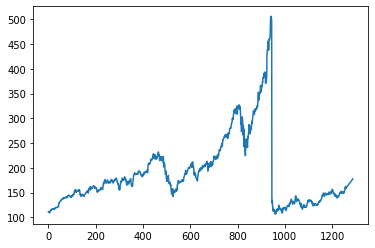

In [167]:
print(df3)
plt.plot(df3)

In [168]:
df4=pd.DataFrame(df3, columns=['predict'])

df=pd.read_csv("Stock.csv")

df=pd.concat([df,df4], axis=1)
print(df)
df.to_csv("predict.csv")

     symbol                       date  ...  splitFactor     predict
0      AAPL  2016-11-28 00:00:00+00:00  ...          1.0  111.570000
1      AAPL  2016-11-29 00:00:00+00:00  ...          1.0  111.460000
2      AAPL  2016-11-30 00:00:00+00:00  ...          1.0  110.520000
3      AAPL  2016-12-01 00:00:00+00:00  ...          1.0  109.490000
4      AAPL  2016-12-02 00:00:00+00:00  ...          1.0  109.900000
...     ...                        ...  ...          ...         ...
1283    NaN                        NaN  ...          NaN  174.799342
1284    NaN                        NaN  ...          NaN  175.481541
1285    NaN                        NaN  ...          NaN  176.170416
1286    NaN                        NaN  ...          NaN  176.866078
1287    NaN                        NaN  ...          NaN  177.568558

[1288 rows x 15 columns]


In [169]:
import datetime
b=datetime.datetime.today()
a = b- datetime.timedelta(days=1259)
print(b,a)
numdays = 1300
dateList = []
for x in range (0, numdays):
    dateList.append(a + datetime.timedelta(days=x))
print(dateList)

2021-11-26 14:39:03.056043 2018-06-16 14:39:03.056043
[datetime.datetime(2018, 6, 16, 14, 39, 3, 56043), datetime.datetime(2018, 6, 17, 14, 39, 3, 56043), datetime.datetime(2018, 6, 18, 14, 39, 3, 56043), datetime.datetime(2018, 6, 19, 14, 39, 3, 56043), datetime.datetime(2018, 6, 20, 14, 39, 3, 56043), datetime.datetime(2018, 6, 21, 14, 39, 3, 56043), datetime.datetime(2018, 6, 22, 14, 39, 3, 56043), datetime.datetime(2018, 6, 23, 14, 39, 3, 56043), datetime.datetime(2018, 6, 24, 14, 39, 3, 56043), datetime.datetime(2018, 6, 25, 14, 39, 3, 56043), datetime.datetime(2018, 6, 26, 14, 39, 3, 56043), datetime.datetime(2018, 6, 27, 14, 39, 3, 56043), datetime.datetime(2018, 6, 28, 14, 39, 3, 56043), datetime.datetime(2018, 6, 29, 14, 39, 3, 56043), datetime.datetime(2018, 6, 30, 14, 39, 3, 56043), datetime.datetime(2018, 7, 1, 14, 39, 3, 56043), datetime.datetime(2018, 7, 2, 14, 39, 3, 56043), datetime.datetime(2018, 7, 3, 14, 39, 3, 56043), datetime.datetime(2018, 7, 4, 14, 39, 3, 56043),

In [170]:
import plotly.graph_objects as go
fig = go.Figure([go.Scatter(x=dateList, y=df['predict'])])
fig.show()